In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [20]:
from dateutil.relativedelta import relativedelta
import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# Print all of the classes mapped to the Base
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# reflect the tables
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff4cc4955d0>,
 'date': '2010-01-01',
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff4cc420310>,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Climate Analysis

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
res = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_str = res[0]
last_date = datetime.datetime.strptime(last_date_str, '%Y-%m-%d')
year_before = last_date - relativedelta(years=1)
print(last_date)
print(year_before)

2017-08-23 00:00:00
2016-08-23 00:00:00


In [31]:
# Perform a query to retrieve the data and precipitation scores
precip_year_res = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_before).\
order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precip_year_res, columns = ["Date", "Precipitation"]).set_index('Date')
precipitation_df["Precipitation"] = precipitation_df["Precipitation"].fillna(0)
precipitation_df.head()

Precipitation
Date                     
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24           0.00
2016-08-24           1.22

In [34]:
# Sort the dataframe by date
precipitation_df.sort_values(by=['Date'])

Precipitation
Date                     
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24           0.00
2016-08-24           1.22
...                   ...
2017-08-22           0.50
2017-08-23           0.08
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.45

[2223 rows x 1 columns]

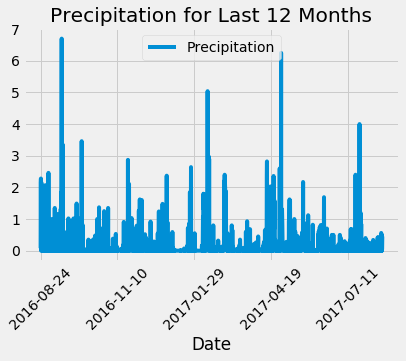

In [42]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(y = "Precipitation",title = "Precipitation for Last 12 Months", rot = 45)
plt.show()

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

Precipitation
count    2223.000000
mean        0.159951
std         0.441220
min         0.000000
25%         0.000000
50%         0.010000
75%         0.110000
max         6.700000

In [49]:
# Design a query to show how many stations are available in this dataset?
stations_res = session.query(Measurement.station).distinct().count()
print(f"Available Stations: {stations_res}")

Available Stations: 9


In [51]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = active_stations[0][0]
most_active_temps = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Most Active Station Summary:")
print(f"Lowest: {most_active_temps[0][0]} Highest: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

Most Active Station Summary:
Lowest: 54.0 Highest: 85.0 Average: 71.7


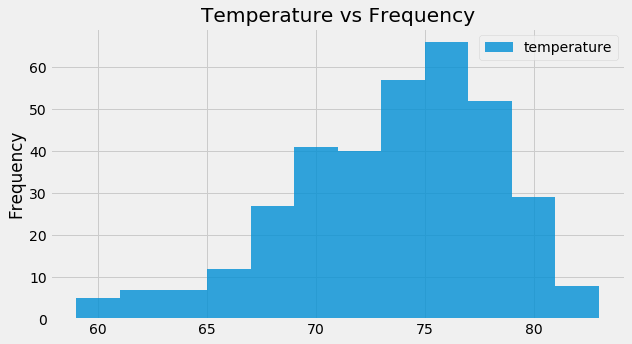

In [56]:
# Choose the station with the highest number of temperature observations.
highest_tobs_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
highest_tobs_station = highest_tobs_station[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query( Measurement.tobs).filter(Measurement.date >= year_before).filter(Measurement.station == highest_tobs_station).all()
tobs_df = pd.DataFrame(tobs, columns=['temperature'])

tobs_df.plot.hist(bins=12, title="Temperature vs Frequency", alpha=0.8, figsize=(9,5))
plt.tight_layout()
plt.style.use('fivethirtyeight')
plt.savefig("Images/TemperaturevsFrequency.png")
plt.show()